==============================================================================================
## Practicum 5: Image search using textures


==============================================================================================



The exercises of this notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture and color

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.


## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): December 8th, 23:00 h** 


 The function should return a feature vector obtained by averaging each filter response on the image.  

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

## Looking at the images

In [67]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
import os
from skimage.transform import resize

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Resize dimension 250 x 250
x = 250
y = 250

path = "./images/texturesimages/pizza/"                       
pizza_images = [resize(skimage.io.imread(path + f), (x, y)) for f in os.listdir(path)]

path = "./images/texturesimages/fish_and_chips/"
fishandchips_images = [resize(skimage.io.imread(path + f), (x, y)) for f in os.listdir(path)]

path = "./images/texturesimages/paella/"
paella_images = [resize(skimage.io.imread(path + f), (x, y)) for f in os.listdir(path)]


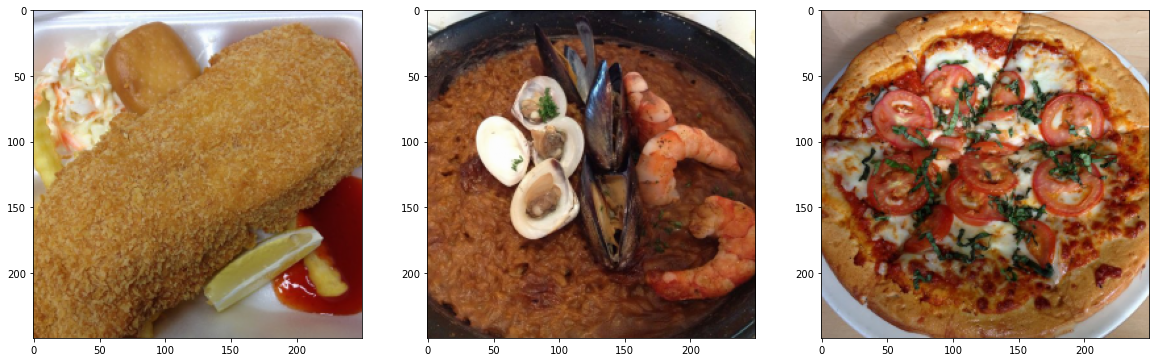

In [69]:
fig, ax= plt.subplots(ncols=3, nrows=1, figsize=(20,30))

ax[0].imshow(fishandchips_images[0])
ax[1].imshow(paella_images[0])
ax[2].imshow(pizza_images[0])
plt.show()

In [70]:
len(fishandchips_images), len(paella_images), len(paella_images)

(30, 30, 30)

# Filter banks

We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


## Leung-Malik (LM) Filter Bank

In [71]:
import LM_filters

In [72]:
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

(49, 49, 48)

### Plotting all filters

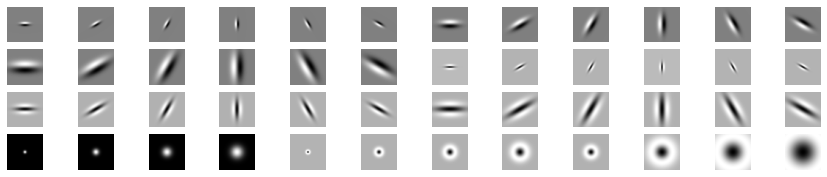

In [73]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1


## Exercise 5.1 Plot the convolved image by some of the filters


Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png">


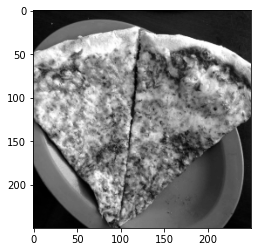

In [74]:
im = pizza_images[5]
im = skimage.color.rgb2gray(im)
plt.imshow(im, cmap="gray")

[0.00097608 0.00179285 0.00101923 0.00041474 0.00078288]
[-5.97486051e-04 -5.90705193e-04  3.07577624e-05  7.54911971e-04
  8.38902990e-04]
[-0.00029901 -0.00037341 -0.00051676 -0.00071768 -0.00091364]
[-0.00067069 -0.00065975 -0.00063771 -0.00060456 -0.00056091]
[-2.75577480e-04 -2.67825917e-04 -2.21790082e-04 -7.96670879e-05
  1.74841524e-04]


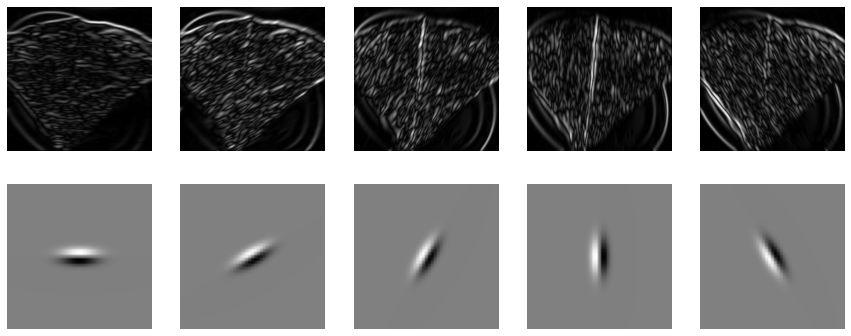

In [75]:
'''Solution'''

def visualize_features(im,  filter_bank, n_filters=5):

    ### Apply first 5 filters from the filter bank
    fig, ax = plt.subplots(ncols=n_filters, nrows=2, figsize=(15,6))

    for i in range(n_filters):
        n_filter = i
        im_conv = np.zeros(im.shape)
        mask = filter_bank[:,:,n_filter]

        scipy.ndimage.convolve(im, mask, output=im_conv)
        print(im_conv[:5,0])
        ax[0,i].imshow(np.abs(im_conv),cmap='gray')
        ax[0,i].axis("off")

        ax[1,i].imshow( filter_bank[:,:,n_filter], cmap="gray")
        ax[1,i].axis("off")
        
visualize_features(im, filter_bank)



## Exercise 5.2 Constructing a feature vector for a given image


Given $D$ filters from the filter bank and a single image `image`, make a function `features_from_filter_bank(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$



In [76]:
%%time
'''Solution'''
im = skimage.color.rgb2gray(pizza_images[0])

def features_from_filter_bank(image, filter_bank, n_filters):
    im_conv = np.zeros(image.shape)
    features_for_im = np.zeros(n_filters)
    
    for i in range(n_filters):
        scipy.ndimage.convolve(image, filter_bank[:,:,i], output=im_conv)
        features_for_im[i] = np.mean(np.abs(im_conv))
  
    return features_for_im

n_filters = filter_bank.shape[-1]
features_for_im = features_from_filter_bank(im, filter_bank, n_filters)

Wall time: 10.2 s


## Exercise 5.3 Constructing the matrix of the feature vectors for all images

Implement a function `get_class_Features(all_images, filter_bank)` that applies `features_from_filter_bank` to get a feature vector for each of the images in the union of the three datasets (paella, pizza, fish and chips). It must return a matrix containing at row $k$ feature vector for the input image $k$.


Wall time: 7min 49s

In [77]:
all_images = pizza_images + paella_images + fishandchips_images

In [78]:
%%time
'''
Solution
'''
def get_class_features(all_images,  filter_bank):

    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    all_feature_vectors=np.zeros((n_images,filter_bank.shape[-1]))
    t0 = time.time()
    for k,image in enumerate(all_images):
        
        print('processing image ',k)

        # Get black and white image
        image_gray = skimage.color.rgb2gray(all_images[k])

        # Get the feature vector for the current image
        all_feature_vectors[k] = features_from_filter_bank(image_gray, filter_bank, n_filters)
        
        # Print time and current image
        #print (" Processing image ",k+1, "/" + str(n_images), "time: ", time.time()-t0, " sec", end="\r")
        
    return all_feature_vectors

Wall time: 0 ns


In [79]:
all_feature_vectors=get_class_features(all_images, filter_bank)

processing image  0
processing image  1
processing image  2
processing image  3
processing image  4
processing image  5
processing image  6
processing image  7
processing image  8
processing image  9
processing image  10
processing image  11
processing image  12
processing image  13
processing image  14
processing image  15
processing image  16
processing image  17
processing image  18
processing image  19
processing image  20
processing image  21
processing image  22
processing image  23
processing image  24
processing image  25
processing image  26
processing image  27
processing image  28
processing image  29
processing image  30
processing image  31
processing image  32
processing image  33
processing image  34
processing image  35
processing image  36
processing image  37
processing image  38
processing image  39
processing image  40
processing image  41
processing image  42
processing image  43
processing image  44
processing image  45
processing image  46
processing image  47
pr

## Exercise 5.4 Visualizing the features of an image

Define a function `visualize_features` that given a feature index and an array containing all feature vectors, plots its values for the three datasets using different colors for each dataset (in total plots should contain 3 colors).


(90, 48)


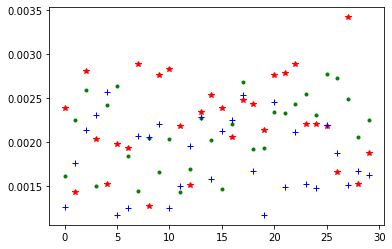

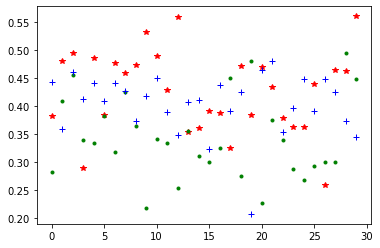

In [80]:
'''Solution'''
def visualize_features(k, all_feature_vectors):
    plt.plot(all_feature_vectors[0:30,k],'r*')
    plt.plot(all_feature_vectors[30:60,k],'g.')
    plt.plot(all_feature_vectors[60:90,k],'b+')
    plt.show()

print (all_feature_vectors.shape)

visualize_features(25, all_feature_vectors)    
visualize_features(41, all_feature_vectors)    





#### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$


## Exercise 5.5 Retrieving the most similar and different images



Implement a function `retrieve_k_images_from_X(query, X, k)` where `query` is an image,  `X` ins the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar and distant images (according to the l2 norm) and the distances from the closest and the furthest images to the query image. You can include the query image since it is in `X`.

- Make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

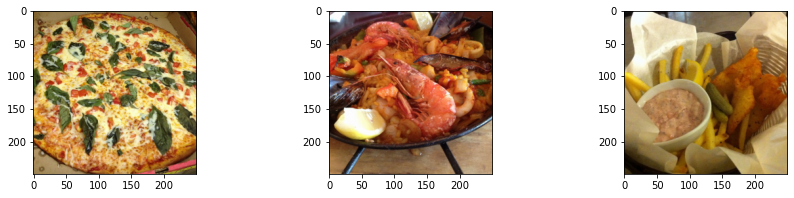

In [81]:
X = np.array(all_feature_vectors)
ind_1 = 10
ind_2 = 40
ind_3 = 70

query_1 = X[10, :]
query_2 = X[40,:]
query_3 = X[70,:]

# Display the query images
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
ax[0].imshow(all_images[10]) 
ax[1].imshow(all_images[40])
ax[2].imshow(all_images[70])

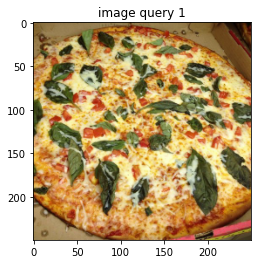

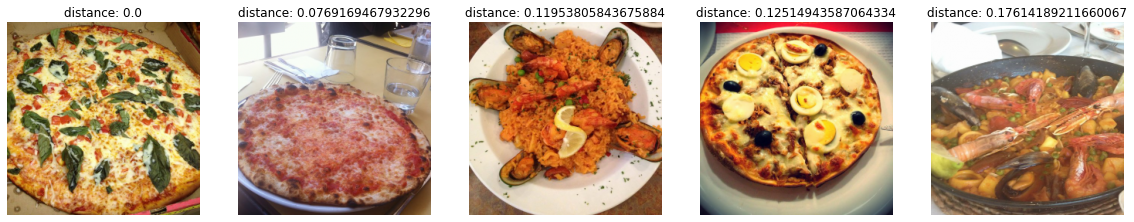

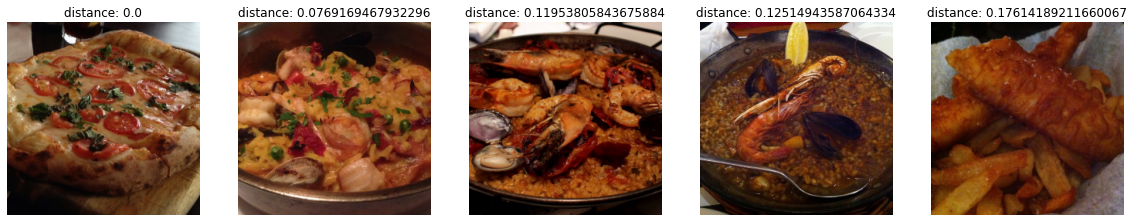

In [82]:
'''Solution'''


def retrieve_k_images_from_X(query, X, k):
    
    distances = np.sqrt(np.sum((X - query)**2, axis=1))
    closest_to_query = np.argsort(distances)
    closest_images = [all_images[ind] for ind in closest_to_query[0:k]]
    furthest_images = [all_images[ind] for ind in closest_to_query[-k:]]
    return closest_images, furthest_images,distances

def print_closest_image_to_query(closest_images, distances):
    fig, ax= plt.subplots(ncols=5, nrows=1, figsize=(20,30))
    for i, im in enumerate(closest_images):
        ax[i].imshow(im)
        ax[i].axis("off")
        ax[i].set_title('distance: ' + str(np.sort(distances)[i]))
        
ind_1 = 10
ind_2 = 40
ind_3 = 70

query_1 = X[10, :]
query_2 = X[40,:]
query_3 = X[70,:]

im_query1 = all_images[ind_1]
im_query2 = all_images[ind_2]
im_query3 = all_images[ind_3]

plt.imshow(im_query1)
plt.title('image query 1')
plt.show()
closest_images_1, furthest_images_1, distances_1 = retrieve_k_images_from_X(query_1, X, 5)
print_closest_image_to_query(closest_images_1, distances_1)
print_closest_image_to_query(furthest_images_1, distances_1)




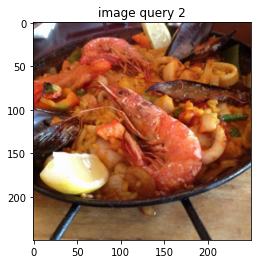

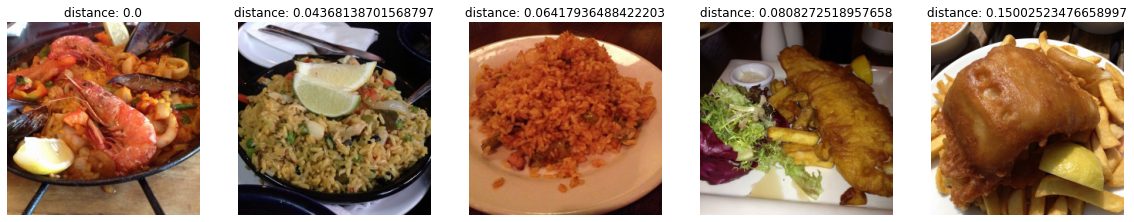

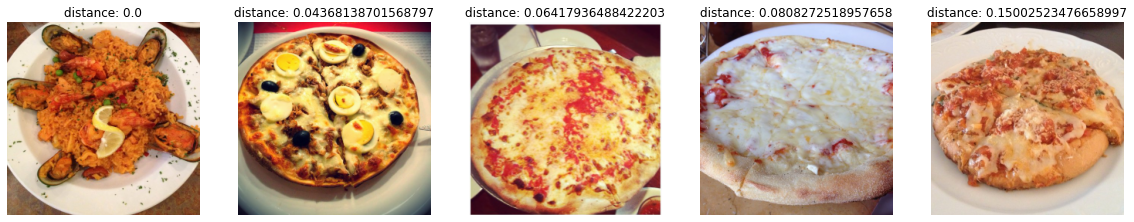

In [83]:
plt.imshow(im_query2)
plt.title('image query 2')
plt.show()
closest_images_2, furthest_images_2, distances_2 = retrieve_k_images_from_X(query_2, X, 5)
print_closest_image_to_query(closest_images_2, distances_2)
print_closest_image_to_query(furthest_images_2, distances_2)


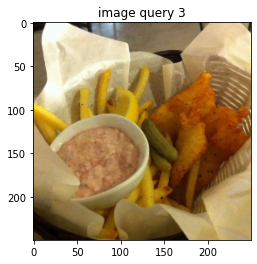

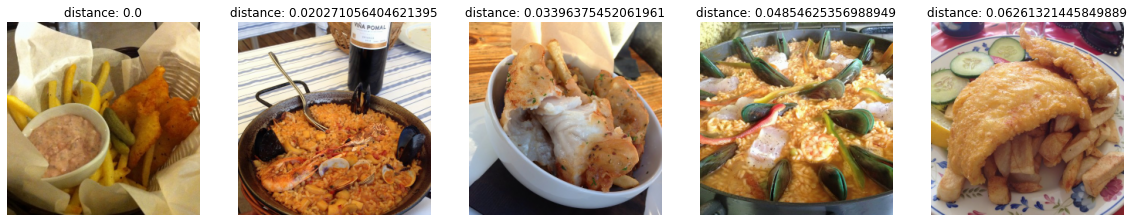

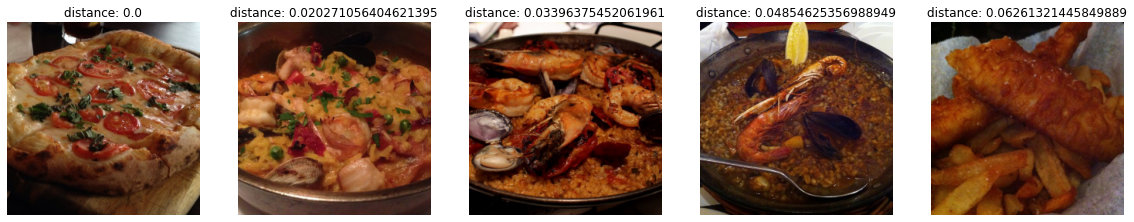

In [84]:
plt.imshow(im_query3)
plt.title('image query 3')
plt.show()
closest_images_3, furthest_images_3, distances_3 = retrieve_k_images_from_X(query_3, X, 5)
print_closest_image_to_query(closest_images_3, distances_3)
print_closest_image_to_query(furthest_images_3, distances_3)

## Exercise 5.6 Compute the accuracy of the algorithm: given a query image. 

Make a function 

```
accuracy(X, class_labels, k=5, query=x, class_query=y)
```

That takes as input a the dataset `X`, the `class_labels` for the images, the number of images to retrieve `k`, a query image `x` and the class of the query image `y`. Returns as output the number of retrieved images that belong to class `y` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: be careful to exclude the query image from the retrieved images.



- Compute the accuracy with k=4 with the previous images. Does the accuracy match the images retrieved from the previous exercise?



In [85]:
class_labels = np.concatenate((np.zeros(30), np.ones(30),  2*np.ones(30))).reshape(90,1)

In [86]:
'''
Solution
'''
def accuracy(X, class_labels, k, query, class_query):
    distances = np.sqrt(np.sum((X - query)**2, axis=1))
    closest_to_query = np.argsort(distances)
    perm = np.argsort(distances)
    #print(perm)
    y_pred = class_labels[perm][1:k+1]                            # do not take into account query image
    #print("e", class_labels[perm])
    print("predicted classes of k closest classes:", y_pred.T)
    acc = np.mean(y_pred == class_query)
    return acc


ind_query = ind_1
print("acc:", accuracy(X, class_labels, k=4, query=X[ind_query ,:], class_query=class_labels[ind_query]))

ind_query = ind_2
print("acc:", accuracy(X, class_labels, k=4, query=X[ind_query ,:], class_query=class_labels[ind_query]))

ind_query = ind_3
print("acc:", accuracy(X, class_labels, k=4, query=X[ind_query ,:], class_query=class_labels[ind_query]))


predicted classes of k closest classes: [[0. 1. 0. 1.]]
acc: 0.5
predicted classes of k closest classes: [[1. 1. 2. 2.]]
acc: 0.5
predicted classes of k closest classes: [[1. 2. 1. 2.]]
acc: 0.5


- Compute the accuracy for both cases, when X is obtained by (A) applying the bank of filters or (B) the color information.



- Compare the results obtained. Which descriptors give better performance? Can you explain why?

## Exercise 5.7 Image retrieval based on texture and color. 

Make a function ` lm_features_rgb(image, filter_bank)`  that returns the features from the filter bank concatenated per color. If the previous feature vectors had 49 components now they will have 49*3 components. 


In [87]:
'''
Solution
'''
def lm_features_rgb(image, filter_bank):

    n_filters = len(filter_bank)
    im_conv = np.array(image[:,:,0])
    features_for_im = np.zeros(3*n_filters)
    k = 0
    
    for i in range(n_filters-1):
        scipy.ndimage.convolve(image[:,:,0], filter_bank[:,:,i] , output=im_conv)
        features_for_im[k] =  np.abs(im_conv).mean()
        
        scipy.ndimage.convolve(image[:,:,1], filter_bank[:,:,i] , output=im_conv)
        features_for_im[k+1] =  np.abs(im_conv).mean()
        
        scipy.ndimage.convolve(image[:,:,2], filter_bank[:,:,i] , output=im_conv)
        features_for_im[k+2] =  np.abs(im_conv).mean()
        
        k = i + 3        
        
    return features_for_im

In [88]:
%%time 
lm_rgb_features = lm_features_rgb(all_images[0], filter_bank)

Wall time: 27.1 s


In [89]:
lm_rgb_features.shape

(147,)

## Exercise 5.8 Apply the function to all the images in the dataset

Using ` lm_features_rgb(image, filter_bank)` build the features of all the datapoints in and save them in `X_lm_rgb`.
You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [ ]:
%%time 
'''
Solution
'''
# Around 24 minutes
X_lm_rgb = []
n_images = len(all_images)

t0 = time.time()
for k,image in enumerate(all_images):
    X_lm_rgb.append(lm_features_rgb(image, filter_bank))
    print ("processing image ",k, "/" + str(n_images), "time: ", time.time()-t0, " sec", end="\r")
    
X_lm_rgb = np.array(X_lm_rgb)

In [ ]:
%%time
'''
Solution 2
'''
import joblib
X_lm_rgb = joblib.Parallel(n_jobs=8)(joblib.delayed(lm_features_rgb)(im, filter_bank) for im in all_images)

## 5.9 Compute the accuracy of the method using lm rgb features

Use the function implemented in 5.6 to compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

- Is the accuracy higher?

In [ ]:
X_lm_rgb = np.array(X_lm_rgb)

In [ ]:
ind_query = ind_1
closest_images_1, furthest_images_1, distances_1 = retrieve_k_images_from_X(X_lm_rgb[ind_query ,:], X_lm_rgb, 5)
print_closest_image_to_query(closest_images_1, distances_1)

ind_query = ind_2
closest_images_2,  furthest_images_2, distances_2 = retrieve_k_images_from_X(X_lm_rgb[ind_query ,:], X_lm_rgb, 5)
print_closest_image_to_query(closest_images_2, distances_2)

ind_query = ind_3

closest_images_3,  furthest_images_3, distances_3 = retrieve_k_images_from_X(X_lm_rgb[ind_query ,:], X_lm_rgb, 5)
print_closest_image_to_query(closest_images_3, distances_3)

In [ ]:
ind_query = ind_1
print("acc:", accuracy(X_lm_rgb , class_labels, k=4, query=X_lm_rgb[ind_query ,:], class_query=class_labels[ind_query]))
      
ind_query = ind_2
print("acc:", accuracy(X_lm_rgb, class_labels, k=4, query=X_lm_rgb[ind_query ,:], class_query=class_labels[ind_query]))

ind_query = ind_3
print("acc:", accuracy(X_lm_rgb, class_labels, k=4, query=X_lm_rgb[ind_query ,:], class_query=class_labels[ind_query]))
